# P-value Correlations As High-Scoring Tissues are Removed

As tissues that positively contributed to the weights in the model are removed, pvalue correlation to the "all-normals" sample should start to deterioriate. 

# Inputs

In [1]:
import rnaseq_lib3 as r

import os
import pickle

import pymc3 as pm
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt_centered.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

In [3]:
sample_id = 'TCGA-CZ-5456-01'
sample = tumor.loc[sample_id]

# Normal Sample

## Run Full Model

In [14]:
serial_dir = '/mnt/research_serializations/Pvalue-Correlation-As-Tissues-Are-Removed/'
pkl_out = os.path.join(serial_dir, f'{sample.id}-normal.pkl')

In [48]:
classes = sorted(normal.tissue.unique())
if not os.path.exists(pkl_out):
    model_normal, trace_normal = r.outlier.run_model(sample, normal, 'tissue',
                                                     gene_pool=list(genes))
                                                     #beta_func=pm.LogitNormal)
    with open(pkl_out, 'wb') as f:
        pickle.dump(trace_normal, f)
else:
    trace_normal = pickle.load(open(pkl_out, 'rb'))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [09:38<00:00,  6.28draws/s] 


### Tissue Weights

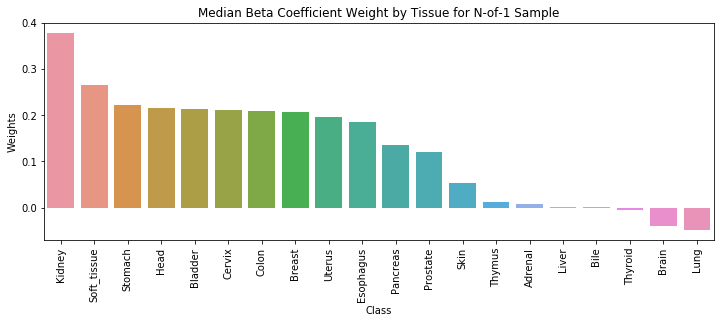

In [49]:
r.outlier.plot_weights(classes, trace_normal)

## Iteratively Remove One Tissue at a Time

In [50]:
pvals = {}
weights = {}
traces = {}
tissue_removal_ord = ['Kidney']
tissue_to_remove = 'Kidney'
sub = normal.copy()
for i in range(len(classes) - 1):
    # Subset dataframe and make class list
    sub = sub[sub.tissue != tissue_to_remove]
    sub_classes = sorted(sub.tissue.unique())
    print(f'Removing {tissue_to_remove}. {len(sub)} samples and {len(sub_classes)} classes remain.')
    
    # Skip if complete
    out_path = os.path.join(serial_dir, f'{sample.id}-{tissue_to_remove}-normal.pkl')
    if os.path.exists(out_path):
        print(f'Skipping {tissue_to_remove} since serialized file exists')
        continue
    
    _, t = r.outlier.run_model(sample, sub, 'tissue', 
                               gene_pool=list(genes))
                               #beta_func=pm.LogitNormal)
    
    #traces[tissue_to_remove] = t
    weights[tissue_to_remove] = r.outlier.calculate_weights(sub_classes, trace=t)
    tissue_to_remove = weights[tissue_to_remove].iloc[0].Class
    tissue_removal_ord.append(tissue_to_remove)
    
    # Serialize trace
    with open(out_path, 'wb') as f:
        pickle.dump(t, f)

Removing Thyroid. 667 samples and 19 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [09:06<00:00,  7.38draws/s] 


Removing Bladder. 648 samples and 18 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [08:05<00:00, 10.77draws/s] 


Removing Head. 604 samples and 17 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [08:13<00:00, 12.16draws/s] 


Removing Kidney. 475 samples and 16 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [07:16<00:00, 13.73draws/s] 


Removing Colon. 424 samples and 15 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [06:05<00:00, 16.41draws/s]


Removing Breast. 312 samples and 14 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:38<00:00, 16.19draws/s]


Removing Soft_tissue. 310 samples and 13 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:27<00:00, 22.47draws/s]


Removing Thymus. 308 samples and 12 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:46<00:00, 20.97draws/s]


Removing Esophagus. 295 samples and 11 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:26<00:00, 16.57draws/s]
The number of effective samples is smaller than 25% for some parameters.


Removing Stomach. 259 samples and 10 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:10<00:00, 23.96draws/s]


Removing Uterus. 236 samples and 9 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [03:34<00:00, 27.95draws/s]


Removing Pancreas. 232 samples and 8 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [03:50<00:00, 25.98draws/s]


Removing Cervix. 229 samples and 7 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [03:14<00:00, 30.81draws/s]


Removing Bile. 220 samples and 6 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [03:38<00:00, 27.51draws/s]


Removing Prostate. 168 samples and 5 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains:  14%|█▎        | 814/6000 [01:30<11:00,  7.85draws/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains: 100%|██████████| 6000/6000 [05:59<00:00,  7.44draws/s]


Removing Lung. 9 samples and 3 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:06<00:00, 89.88draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


Removing Brain. 4 samples and 2 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:54<00:00, 110.58draws/s]


Removing Adrenal. 1 samples and 1 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:21<00:00, 276.89draws/s]


## Calculate PValues 

In [ ]:
rand_genes = np.random.choice(genes, 1000, replace=False)
ppc = r.outlier.ppc_from_coefs(trace_normal, rand_genes, normal, 'tissue', 500)
pvals['normal'] = r.outlier.posterior_predictive_pvals(sample, ppc)

In [53]:
sub = normal.copy()
for i, tissue in enumerate(tissue_removal_ord[:-1]):
    sub = sub[sub.tissue != tissue]
    t = pickle.load(open(os.path.join(serial_dir, f'{sample.id}-{tissue}-normal.pkl'), 'rb'))
    ppc = r.outlier.ppc_from_coefs(t, rand_genes, sub, 'tissue', num_samples=500)
    ppps = r.outlier.posterior_predictive_pvals(sample, ppc)
    pvals[tissue] = ppps

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Pearson Plot

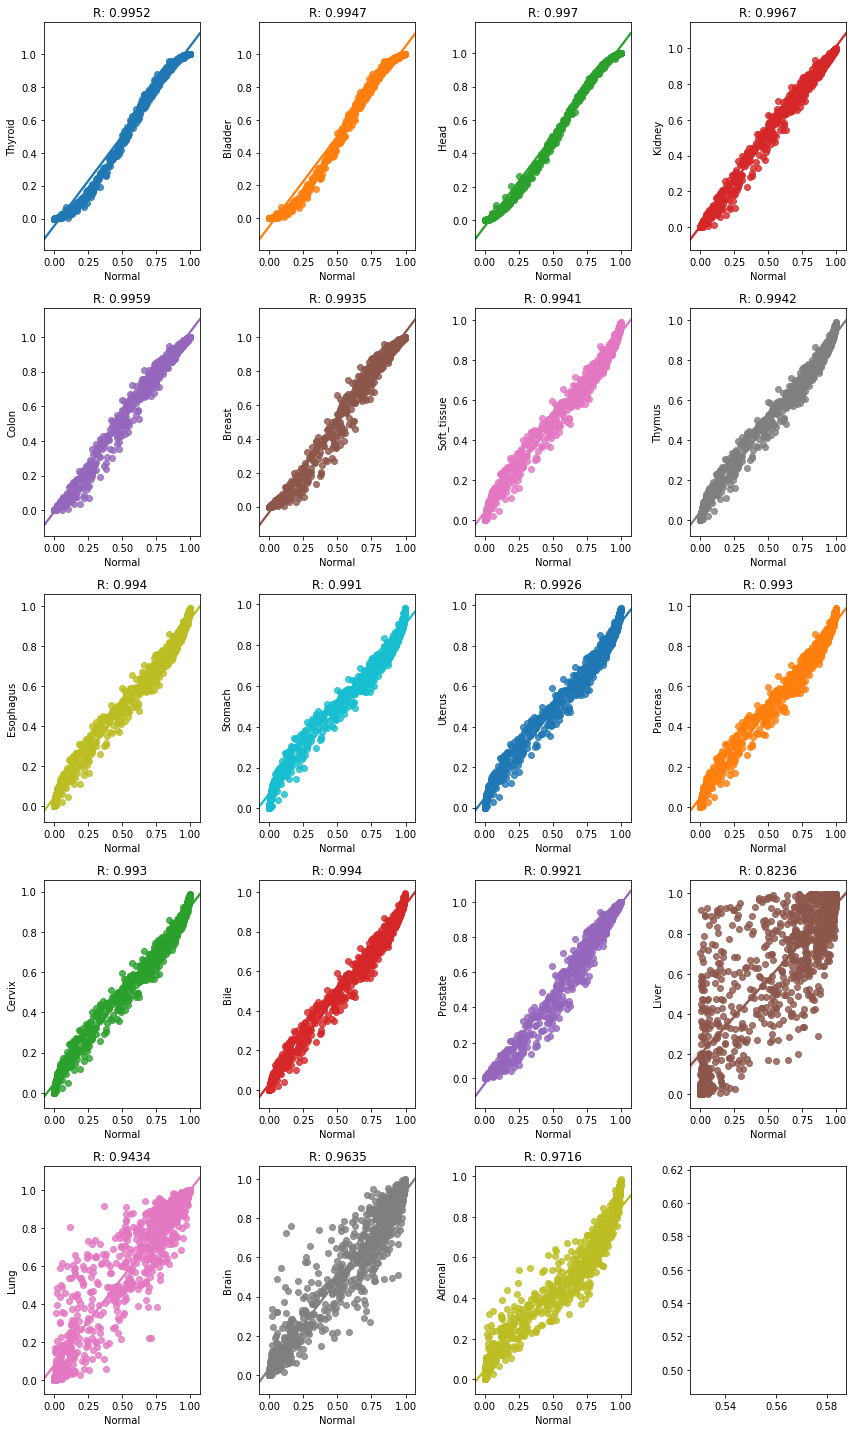

In [54]:
f, ax = plt.subplots(5, 4, figsize=(12, 4*5))
ax = ax.flatten()
i = 0
for tissue in tissue_removal_ord[:-1]:
    plot = pd.DataFrame([pvals['normal'], pvals[tissue]]).T
    plot.columns = ['Normal', tissue]
    pr = round(pearsonr(plot.Normal, plot[tissue])[0], 4)
    sns.regplot(data=plot, x='Normal', y=tissue, ax=ax[i])
    ax[i].set_title(f'R: {pr}')
    i += 1
plt.tight_layout()

## MSE Plot

In [55]:
fit_df = pd.DataFrame([pvals['normal'], pvals['Thyroid']]).T
fit_df.columns = ['Normal', 'Thyroid']
fit = np.polyfit(fit_df.Normal, fit_df.Thyroid, 1)
fit_fn = np.poly1d(fit)

In [32]:
def mse(pval_df):
    val = 0
    for i, row in pval_df.iterrows():
        val += (row.iloc[1] - fit_fn(row.iloc[0])) ** 2
    return val

In [57]:
mses = []
for tissue in tissue_removal_ord[:-1]:
    if tissue in pvals:
        plot = pd.DataFrame([pvals['normal'], pvals[tissue]]).T
        mses.append(mse(plot))

Text(0, 0.5, 'Mean-Squared Error')

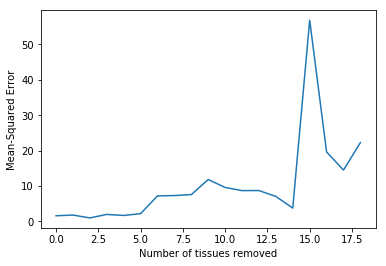

In [58]:
plt.plot(range(len(mses)), mses)
plt.xlabel('Number of tissues removed')
plt.ylabel('Mean-Squared Error')

## Posterior Distributions of Random Genes

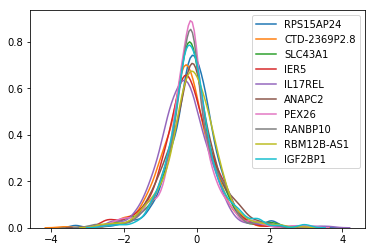

In [43]:
keys = np.random.choice(list(ppc.keys()), 10, replace=False)
for key in keys:
    sns.kdeplot(ppc[key], label=key)

## Weights

In [ ]:
weights

# Do Not Vary Training Genes

Keep one set of training genes for every training

In [9]:
classes = normal.tissue.unique()
training_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', 50)

Traing base model

In [10]:
model_normal, trace_normal = r.outlier.run_model(sample, normal, 'tissue',
                                                 training_genes=training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [12:17<00:00,  5.60draws/s] 


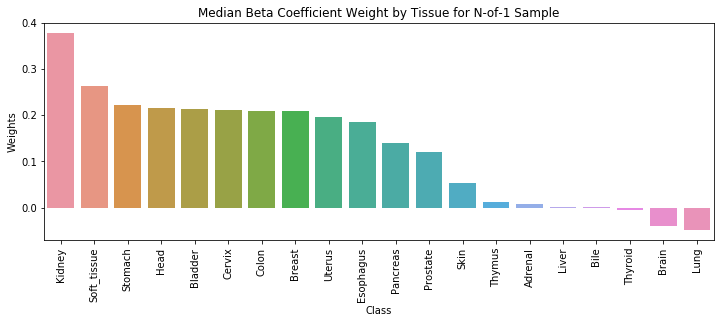

In [11]:
r.outlier.plot_weights(classes, trace_normal)

Iteratively remove one tissue

In [16]:
pvals = {}
weights = {}
traces = {}
tissue_removal_ord = ['Kidney']
tissue_to_remove = 'Kidney'
sub = normal.copy()
for i in range(len(classes) - 1):
    # Subset dataframe and make class list
    sub = sub[sub.tissue != tissue_to_remove]
    sub_classes = sorted(sub.tissue.unique())
    print(f'Removing {tissue_to_remove}. {len(sub)} samples and {len(sub_classes)} classes remain.')
    
    # Skip if complete
    out_path = os.path.join(serial_dir, f'{sample.id}-{tissue_to_remove}-novary-normal.pkl')
#     if os.path.exists(out_path):
#         print(f'Skipping {tissue_to_remove} since serialized file exists')
#         continue
    
    _, t = r.outlier.run_model(sample, sub, 'tissue', 
                               training_genes=training_genes)
                               #beta_func=pm.LogitNormal)
    
    #traces[tissue_to_remove] = t
    weights[tissue_to_remove] = r.outlier.calculate_weights(sub_classes, trace=t)
    tissue_to_remove = weights[tissue_to_remove].iloc[0].Class
    tissue_removal_ord.append(tissue_to_remove)
    
    # Serialize trace
    with open(out_path, 'wb') as f:
        pickle.dump(t, f)

Removing Kidney. 597 samples and 19 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [08:03<00:00,  5.18draws/s] 


Removing Soft_tissue. 595 samples and 18 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [08:01<00:00, 10.56draws/s] 


Removing Stomach. 559 samples and 17 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [07:52<00:00, 10.56draws/s] 


Removing Head. 515 samples and 16 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [07:02<00:00, 10.25draws/s] 


Removing Bladder. 496 samples and 15 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [07:14<00:00, 11.66draws/s] 


Removing Colon. 445 samples and 14 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [05:56<00:00, 16.82draws/s]


Removing Breast. 333 samples and 13 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:58<00:00, 13.82draws/s] 


Removing Cervix. 330 samples and 12 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [05:16<00:00, 14.72draws/s] 


Removing Uterus. 307 samples and 11 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:35<00:00, 21.80draws/s]


Removing Esophagus. 294 samples and 10 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:33<00:00, 21.95draws/s]


Removing Prostate. 242 samples and 9 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [03:55<00:00, 17.04draws/s]


Removing Pancreas. 238 samples and 8 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:12<00:00, 23.80draws/s]


Removing Thymus. 236 samples and 7 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [03:56<00:00, 25.37draws/s]


Removing Liver. 186 samples and 6 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [03:45<00:00, 26.60draws/s]
The number of effective samples is smaller than 25% for some parameters.


Removing Skin. 185 samples and 5 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [03:06<00:00, 32.10draws/s] 


Removing Bile. 176 samples and 4 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [02:53<00:00, 34.49draws/s] 
The number of effective samples is smaller than 25% for some parameters.


Removing Adrenal. 173 samples and 3 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [02:50<00:00, 35.29draws/s] 


Removing Thyroid. 114 samples and 2 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:55<00:00, 44.20draws/s] 
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6379967803225342, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Removing Brain. 109 samples and 1 classes remain.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:41<00:00, 145.96draws/s]


Pvals

In [18]:
rand_genes = np.random.choice(genes, 1000, replace=False)
ppc = r.outlier.ppc_from_coefs(trace_normal, rand_genes, normal, 'tissue', 500)
pvals['normal'] = r.outlier.posterior_predictive_pvals(sample, ppc)

In [ ]:
sub = normal.copy()
for i, tissue in enumerate(tissue_removal_ord[:-1]):
    sub = sub[sub.tissue != tissue]
    t = pickle.load(open(os.path.join(serial_dir, f'{sample.id}-{tissue}-novary-normal.pkl'), 'rb'))
    ppc = r.outlier.ppc_from_coefs(t, rand_genes, sub, 'tissue', num_samples=500)
    ppps = r.outlier.posterior_predictive_pvals(sample, ppc)
    pvals[tissue] = ppps

## Pearson Plot

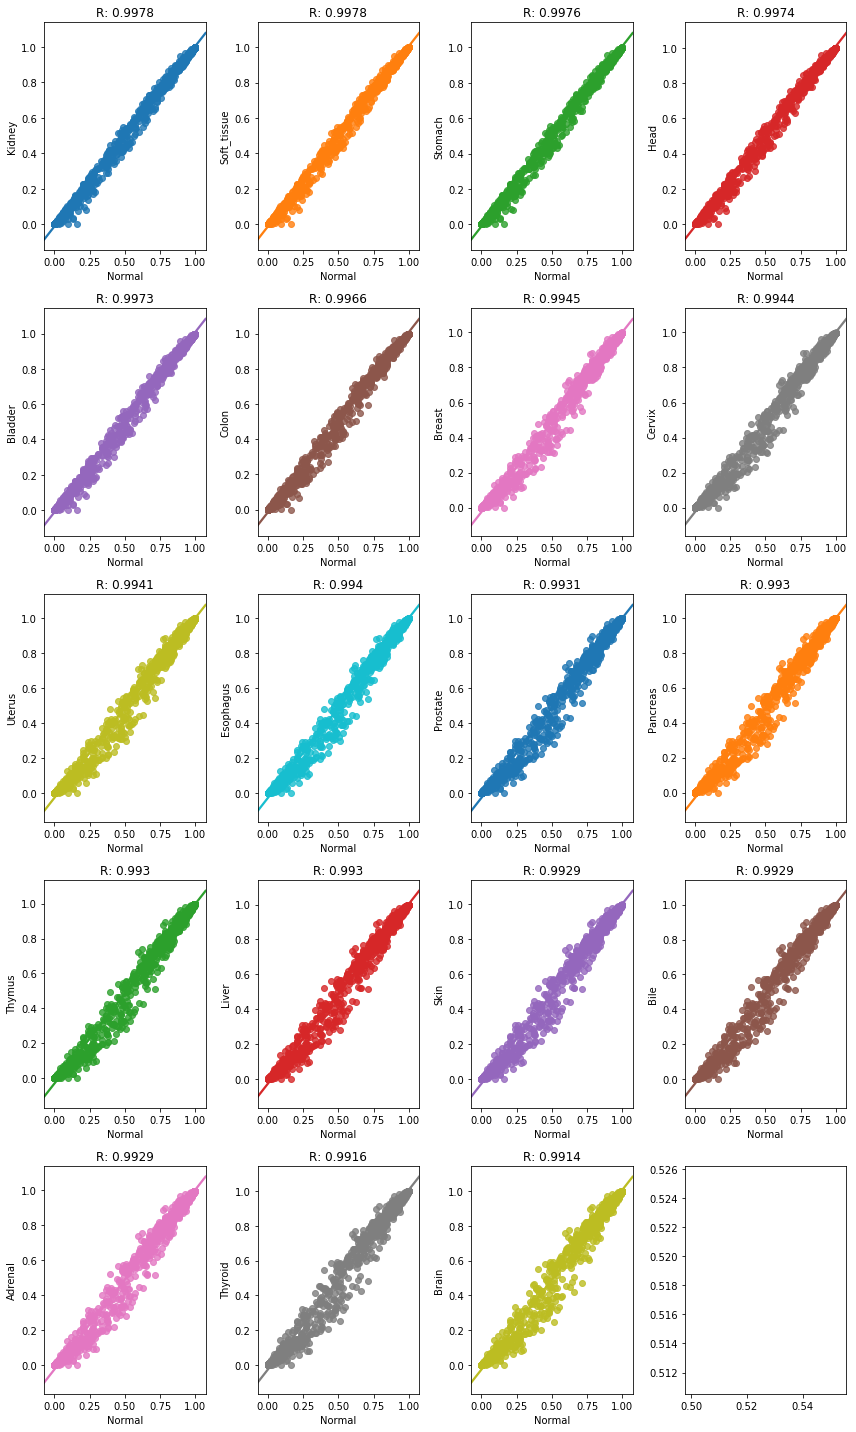

In [28]:
f, ax = plt.subplots(5, 4, figsize=(12, 4*5))
ax = ax.flatten()
i = 0
for tissue in tissue_removal_ord[:-1]:
    plot = pd.DataFrame([pvals['normal'], pvals[tissue]]).T
    plot.columns = ['Normal', tissue]
    pr = round(pearsonr(plot.Normal, plot[tissue])[0], 4)
    sns.regplot(data=plot, x='Normal', y=tissue, ax=ax[i])
    ax[i].set_title(f'R: {pr}')
    i += 1
plt.tight_layout()

## MSE

In [30]:
fit_df = pd.DataFrame([pvals['normal'], pvals['Kidney']]).T
fit_df.columns = ['Normal', 'Kidney']
fit = np.polyfit(fit_df.Normal, fit_df.Kidney, 1)
fit_fn = np.poly1d(fit)

In [33]:
mses = []
for tissue in tissue_removal_ord[:-1]:
    if tissue in pvals:
        plot = pd.DataFrame([pvals['normal'], pvals[tissue]]).T
        mses.append(mse(plot))

Text(0, 0.5, 'Mean-Squared Error')

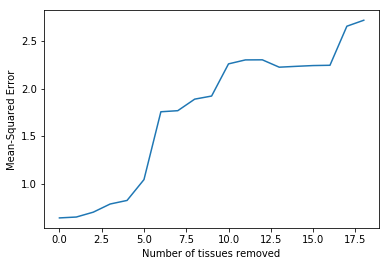

In [34]:
plt.plot(range(len(mses)), mses)
plt.xlabel('Number of tissues removed')
plt.ylabel('Mean-Squared Error')

# Test Area

In [43]:
two_tissue = normal[(normal.tissue == 'Brain') | (normal.tissue == 'Thyroid')]
m_tt, t_tt = r.outlier.run_model(sample,
                                 two_tissue,
                                 'tissue',
                                 training_genes=training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [02:17<00:00, 43.48draws/s] 
The number of effective samples is smaller than 25% for some parameters.


Get PPC for normal data

In [42]:
ppc_normal = pm.sample_ppc(trace=trace_normal, model=model_normal)

100%|██████████| 500/500 [00:26<00:00, 19.09it/s]


In [119]:
trace_normal.varnames

['a', 'mu_b', 'sigma_b_log__', 'b', 'eps_log__', 'sigma_b', 'eps']

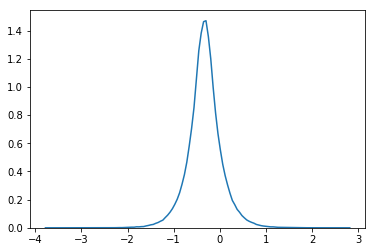

In [123]:
sns.kdeplot(ppc_normal['SFTPC'].ravel())

Compare to Two-Tissue example

In [44]:
ppc_tt = pm.sample_ppc(trace=t_tt, model=m_tt)

100%|██████████| 500/500 [00:26<00:00, 18.61it/s]


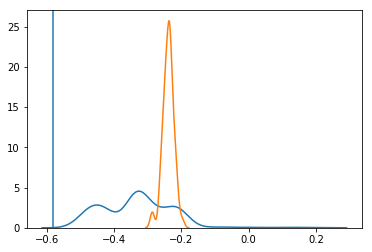

In [89]:
plt.axvline(sample['SFTPC'])
sns.kdeplot(ppc_normal['SFTPC'].mean(axis=0))
sns.kdeplot(ppc_tt['SFTPC'].mean(axis=0))

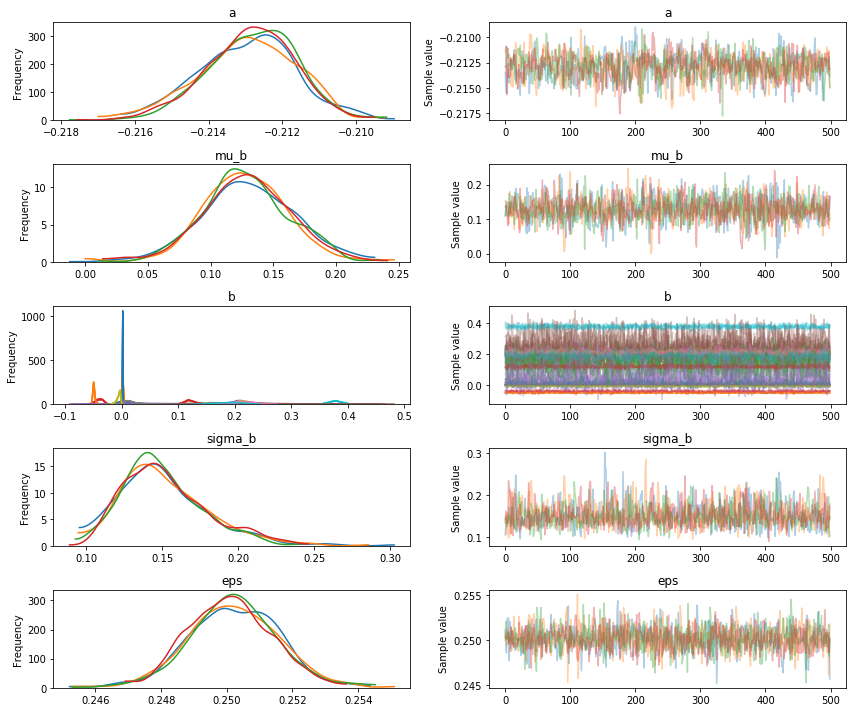

In [116]:
pm.traceplot(trace_normal);

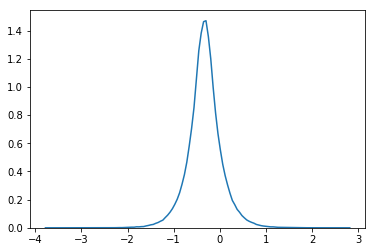

In [113]:
sns.kdeplot(ppc_normal['SFTPC'].ravel())

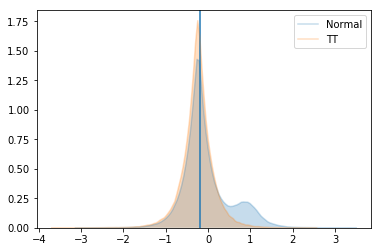

In [90]:
gene = 'HRG'
plt.axvline(sample[gene])
sns.kdeplot(ppc_normal[gene].ravel(), label='Normal', shade=True, alpha=0.25)
sns.kdeplot(ppc_tt[gene].ravel(), label='TT', shade=True, alpha=0.25)

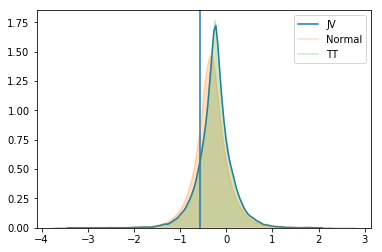

In [96]:
gene = 'SFTPC'
plt.axvline(sample[gene])
sns.kdeplot(ppc_normal[gene].ravel(), label='Normal', shade=True, alpha=0.25)
sns.kdeplot(ppc_tt[gene].ravel(), label='TT', shade=True, alpha=0.25)

In [98]:
jv_ppc_tt = r.outlier.ppc_from_coefs(t_tt, training_genes, two_tissue, 'tissue', 500)
jv_ppc_normal = r.outlier.ppc_from_coefs(trace_normal, training_genes, normal, 'tissue', 500)

My PPC method is identical to theirs for laplacian looking distributions

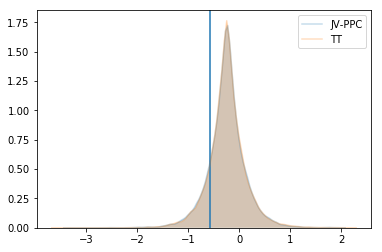

In [97]:
gene = 'SFTPC'
plt.axvline(sample[gene])
sns.kdeplot(jv_ppc_tt[gene], label='JV-PPC', shade=True, alpha=0.25)
sns.kdeplot(ppc_tt[gene].ravel(), label='TT', shade=True, alpha=0.25)

It even exactly matches the "mixture" looking distributions

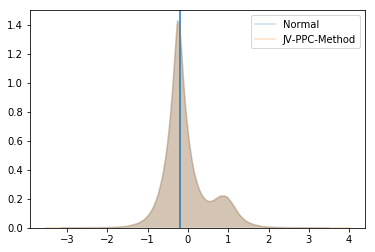

In [102]:
gene = 'HRG'
plt.axvline(sample[gene])
sns.kdeplot(ppc_normal[gene].ravel(), label='Normal', shade=True, alpha=0.25)
sns.kdeplot(jv_ppc_normal[gene], label='JV-PPC-Method', shade=True, alpha=0.25)

# Test Non-Centered Data

In [104]:
path = '/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5'
df_norm = pd.read_hdf(path)
normal_norm = df_norm[df_norm.label == 'tcga-normal']
tt_norm = normal_norm[(normal_norm.tissue == 'Brain') | (normal_norm.tissue=='Thyroid')]

In [108]:
m_norm, t_norm = r.outlier.run_model(sample, 
                                     normal_norm,
                                     'tissue',
                                     training_genes=training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [10:18<00:00,  8.43draws/s] 
